<a href="https://colab.research.google.com/github/minthammock-development/Technical-Assignments/blob/main/RingCentral_Workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RingCentral Data Analysis
This notebook is going to investigate some high level trends in a dataset provided courtesy of RingCentral



## Import Dependancies

In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression
!pip install statsmodels
import statsmodels as sm
sm.test()

import warnings
warnings.filterwarnings('ignore')

Running pytest /usr/local/lib/python3.7/dist-packages/statsmodels --tb=short --disable-pytest-warnings
============================= test session starts ==============================
platform linux -- Python 3.7.10, pytest-3.6.4, py-1.10.0, pluggy-0.7.1
rootdir: /usr/local/lib/python3.7/dist-packages/statsmodels, inifile: setup.cfg
plugins: typeguard-2.7.1


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



collected 7732 items / 3 errors

==================================== ERRORS ====================================
__________________ ERROR collecting genmod/tests/test_glm.py ___________________
/usr/local/lib/python3.7/dist-packages/statsmodels/genmod/tests/test_glm.py:1894: in <module>
    @pytest.mark.filterwarnings("ignore:GLM ridge optimization")
/usr/local/lib/python3.7/dist-packages/_pytest/mark/structures.py:367: in __getattr__
    self._check(name)
/usr/local/lib/python3.7/dist-packages/_pytest/mark/structures.py:383: in _check
    raise AttributeError("%r not a registered marker" % (name,))
E   AttributeError: 'filterwarnings' not a registered marker
_____________ ERROR collecting tsa/vector_ar/tests/test_dynamic.py _____________
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/vector_ar/tests/test_dynamic.py:44: in <module>
    @pytest.mark.filterwarnings('ignore::FutureWarning')
/usr/local/lib/python3.7/dist-packages/_pytest/mark/structures.py:367: in __getattr__
    

## Custom Functions

In [ ]:
# Custom Functions
def breakColumns(df, columns, conditionRevenue = []):
  '''
  This function essentially creates pivot columns for selected row with a little
  more customization. Specifically it tallys us revenue from stage 7 and stage 0
  for decent aggregate data. It also creates some counting columns for the datatime
  index.

  Parameters:
    df - pd.dataframe() object,
    columns - string, name of columns in df to pivot on
    conditionRevenue - list, list of column names for further
                       revenue investigation
  
  Returns:
    Null - alters df inplace so be careful when using
  '''

  for column in columns:
    entries = df[column].value_counts().index
    for entry in entries:
      df[entry] = [1 if x == entry else 0 for x in df[column]]
      if column in conditionRevenue:
        df[f'{entry} Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] == '7. Closed Won') else 0 for i in range(len(df))]
        df[f'{entry} Lost Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] == '0. Downgraded') else 0 for i in range(len(df))]
        df[f'{entry} Qualify Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] ==  '1. Qualify') else 0 for i in range(len(df))]
        df[f'{entry} Problem Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] ==  '2. Problem') else 0 for i in range(len(df))]
        df[f'{entry} Solution Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] == '3. Solution') else 0 for i in range(len(df))]
        df[f'{entry} Proof Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] ==    '4. Proof') else 0 for i in range(len(df))]
        df[f'{entry} Agreement Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] =='5. Agreement') else 0 for i in range(len(df))]
        df[f'{entry} Order Revenue'] = [df['Forecasted Annual Revenue'][i] if (df[column][i] == entry and df['Stage'][i] ==    '6. Order') else 0 for i in range(len(df))]
        df[f'{entry} Closed Sale'] = [1 if (df[column][i] == entry and df['Stage'][i] == '7. Closed Won') else 0 for i in range(len(df))]


## Read In Data

In this section we are going to load in the data into Pandas dataframe objects. These objects function essentially like spredsheets, but they are optimized for efficient computations. 

In [ ]:
# read in data
dfPartners = pd.read_excel('/content/drive/MyDrive/Reporting Working Example-S&D Details-Partner Operations Analyst.xlsx',sheet_name='Partners')
dfOpp = pd.read_excel('/content/drive/MyDrive/Reporting Working Example-S&D Details-Partner Operations Analyst.xlsx', sheet_name='Opportunities')

## Look For Missing Data

We will run through each of the tables to confirm if there are missing values in any of our columns.

In [ ]:
dfPartners.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Partner Name     636 non-null    object
 1   Partner ID       636 non-null    int64 
 2   Channel Manager  636 non-null    object
dtypes: int64(1), object(2)
memory usage: 15.0+ KB


There are no missing entries in the Partner ID table. We now check the transaction table.

In [ ]:
dfOpp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2091 entries, 0 to 2090
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Partner ID                 2091 non-null   int64         
 1   Opportunity Name           2091 non-null   object        
 2   Forecasted Office Users    2085 non-null   float64       
 3   Forecasted Annual Revenue  2091 non-null   float64       
 4   CreateDateTime             2091 non-null   datetime64[ns]
 5   Forecasted Close Date      2091 non-null   datetime64[ns]
 6   Stage                      2091 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(1), object(2)
memory usage: 114.5+ KB


It appears that the only column with missing data is the "Forecasted Office Users" column. Let's investigate the entries with missing data to see if we can spot a pattern.

In [ ]:
# showing all the missing data in the forecasted office users column
dfMissing = dfOpp.loc[dfOpp['Forecasted Office Users'].isna() == True]
dfMissing

,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage
96,58007,Opportunity 3034,NaN,3456.64,2020-11-02 05:07:00,2020-11-02,0. Downgraded
97,58007,Opportunity 3035,NaN,0.00,2020-11-26 05:04:00,2020-11-30,0. Downgraded
855,79248,Opportunity 4480,NaN,657.41,2020-07-09 15:30:00,2020-07-09,0. Downgraded
856,79248,Opportunity 4481,NaN,657.41,2020-07-10 06:45:00,2020-07-10,0. Downgraded
1611,66679,Opportunity 1203,NaN,11066.28,2020-05-21 06:25:00,2020-05-21,7. Closed Won
1770,43376,Opportunity 1615,NaN,314.23,2020-06-09 02:49:00,2020-06-09,7. Closed Won


Let's go ahead and see the other transactions from these partners to see if all the data is missing or only these entries. 

In [ ]:
# taking a look at the partner ids with missing data
for id in dfMissing['Partner ID'].unique():
  display(dfOpp.loc[dfOpp['Partner ID'] == id])

,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage
96,58007,Opportunity 3034,NaN,3456.64,2020-11-02 05:07:00,2020-11-02,0. Downgraded
97,58007,Opportunity 3035,NaN,0.00,2020-11-26 05:04:00,2020-11-30,0. Downgraded
378,58007,Opportunity 3724,5.0,1728.32,2020-02-17 05:18:00,2020-05-15,0. Downgraded
426,58007,Opportunity 3778,1.0,251.35,2020-07-03 10:04:00,2020-07-10,0. Downgraded
1263,58007,Opportunity 501,0.0,216138.33,2021-02-25 06:42:00,2021-08-01,2. Problem
1657,58007,Opportunity 1290,10.0,3456.64,2020-10-22 07:22:00,2020-11-13,7. Closed Won
1868,58007,Opportunity 2162,30.0,1410.01,2020-03-18 16:55:00,2020-03-25,7. Closed Won


,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage
855,79248,Opportunity 4480,NaN,657.41,2020-07-09 15:30:00,2020-07-09,0. Downgraded
856,79248,Opportunity 4481,NaN,657.41,2020-07-10 06:45:00,2020-07-10,0. Downgraded
876,79248,Opportunity 4501,9.0,2613.07,2020-06-19 09:55:00,2020-10-08,0. Downgraded
884,79248,Opportunity 4510,5.0,0.00,2020-07-10 07:06:00,2020-11-24,0. Downgraded
893,79248,Opportunity 4523,12.0,0.00,2020-08-04 07:48:00,2020-10-07,0. Downgraded
897,79248,Opportunity 4527,450.0,155548.86,2020-08-13 03:50:00,2020-10-23,0. Downgraded
901,79248,Opportunity 4531,4.0,0.00,2020-08-26 01:05:00,2020-10-15,0. Downgraded
903,79248,Opportunity 4533,25.0,0.00,2020-08-28 07:06:00,2020-12-18,0. Downgraded
904,79248,Opportunity 4534,4.0,600.90,2020-08-28 07:06:00,2021-04-01,0. Downgraded
909,79248,Opportunity 4539,30.0,0.00,2020-09-08 02:20:00,2021-01-07,0. Downgraded


,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage
22,66679,Opportunity 2944,6.0,1041.56,2020-01-31 06:02:00,2020-02-29,0. Downgraded
24,66679,Opportunity 2946,2.0,534.14,2020-02-03 08:22:00,2020-03-31,0. Downgraded
80,66679,Opportunity 3016,1.0,502.86,2020-07-30 09:58:00,2020-08-04,0. Downgraded
109,66679,Opportunity 3051,50.0,12567.46,2020-12-04 07:36:00,2021-03-31,0. Downgraded
1611,66679,Opportunity 1203,NaN,11066.28,2020-05-21 06:25:00,2020-05-21,7. Closed Won
1615,66679,Opportunity 1216,5.0,942.52,2020-06-04 09:22:00,2020-06-09,7. Closed Won


,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage
269,43376,Opportunity 3356,1.0,235.63,2020-04-21 03:49:00,2020-06-30,0. Downgraded
1718,43376,Opportunity 1530,2.0,518.50,2020-04-29 05:55:00,2020-05-05,7. Closed Won
1770,43376,Opportunity 1615,NaN,314.23,2020-06-09 02:49:00,2020-06-09,7. Closed Won


Looking at the transactions for our partners with missing data, We can use the entries similar in "Forecasted Annual Revenue" to impute the missing data. I would like to point out that if there were a substantial amount of missing data I would likely train a model to impute this data. However, given the limited scale, a quick look at the table can yield good results. 

* Partner ID 58007 I'm going to fill in 10 and 0 for the number of users
* Partner ID 79248 I'm going to fill in 3 users for both
* Partner ID 66679 I'm going to fill in 45 users
* Partner ID 43376 I'm going to fill in 1 user

The following cell is going to impute this data into the table prior to joining. 

In [ ]:
# a lazy loop to fill things in. If missing data was more widespread refactor this to 
# be a function
for id in dfMissing.index:
  if (dfOpp.loc[id,'Partner ID'] == 58007) == True:
    dfOpp.loc[id,'Forecasted Office Users'] = 10
  if (dfOpp.loc[id,'Partner ID'] == 79248).sum() == 1:
    dfOpp.loc[id,'Forecasted Office Users'] = 3
  if (dfOpp.loc[id,'Partner ID'] == 66679).sum() == 1:
    dfOpp.loc[id,'Forecasted Office Users'] = 45
  if (dfOpp.loc[id,'Partner ID'] == 43376).sum() == 1:
    dfOpp.loc[id,'Forecasted Office Users'] = 1

dfOpp['Forecasted Office Users'].isna().sum()

0

Printing 0 at the end has confirmed that we've successfully imputed all the missing values. 

## Join Process
In order to get useful summary stats from these SQL tabels we will need to join them. We will use Partner ID as the joining column. In order for this Join to make sense, we must eleminate any duplicate IDs to avoid merging complications. The following cell will find the Parter IDs that have duplicate Partner Names assigned and drop them from the data. This duplicates will be forwarded on the QA team to investigate the reason.

In [ ]:
# look at the duplicated IDs
display(dfPartners.loc[dfPartners['Partner ID'].duplicated() == True])
dfPartners = dfPartners.drop(dfPartners.loc[dfPartners['Partner ID'].duplicated() == True].index)

,Partner Name,Partner ID,Channel Manager
186,Partner 536,44764,Channel Manager 6
271,Partner 543,56304,Channel Manager 6
298,Partner 490,58007,Channel Manager 4
308,Partner 599,59128,Channel Manager 7
454,Partner 556,74611,Channel Manager 6
456,Partner 533,75119,Channel Manager 5
457,Partner 557,75119,Channel Manager 6
493,Partner 617,79257,Channel Manager 7
498,Partner 618,79265,Channel Manager 7
514,Partner 566,79349,Channel Manager 6


To check whether the duplicates were truly deleted we will count the unique values in the Partner ID column. We should only see 1 for every ID.

In [ ]:
# check to make sure duplicates were dealt with
dfPartners['Partner ID'].value_counts()

79351    1
98652    1
91161    1
60771    1
79744    1
        ..
90159    1
96192    1
44713    1
17064    1
81443    1
Name: Partner ID, Length: 622, dtype: int64

It's worth noting that we also examined the transation table for duplicates and found none. 

In [ ]:
# ensure there are no transaction duplicates
display(dfOpp.loc[dfOpp['Opportunity Name'].duplicated() == True])

,Partner ID,Opportunity Name,Forecasted Office Users,Forecasted Annual Revenue,CreateDateTime,Forecasted Close Date,Stage


In [ ]:
# merge the given tables on partner ID
df = pd.merge(dfPartners, dfOpp, on='Partner ID')

## Create Datetime index

As most of our analysis will focus on time series info, we'll set the timestamp column to be our index

In [ ]:
# remove the integer index and put the datetime column in its place
df.set_index('CreateDateTime', inplace=True)
df.sort_values('CreateDateTime', axis = 0, inplace=True)


## Add additional columns and Pivot

Aggregating data is the primary purpose of this analysis. As such, we will create some columns that make it easier to do this in a clean way. In addition, we will pivot on the channel manager, stage and partner name columns in order to break out individual agent contributions to revenue and opportunity generation. 

In [ ]:
# add some new columns that will be useful for aggregation
df['Opportunity'] = [1 for x in df['Opportunity Name']]
df['Closed Revenue'] = [df['Forecasted Annual Revenue'][i] if df['Stage'][i] == '7. Closed Won' else 0 for i in range(len(df))]
df['Lost Revenue'] = [df['Forecasted Annual Revenue'][i] if df['Stage'][i] == '0. Downgraded' else 0 for i in range(len(df))] 
df['Qualify Revenue'] = [df['Forecasted Annual Revenue'][i] if  df['Stage'][i] ==  '1. Qualify' else 0 for i in range(len(df))]
df['Problem Revenue'] = [df['Forecasted Annual Revenue'][i]  if df['Stage'][i] ==  '2. Problem' else 0 for i in range(len(df))]
df['Solution Revenue'] = [df['Forecasted Annual Revenue'][i] if df['Stage'][i] == '3. Solution' else 0 for i in range(len(df))]
df['Proof Revenue'] = [df['Forecasted Annual Revenue'][i]    if df['Stage'][i] ==    '4. Proof' else 0 for i in range(len(df))]
df['Agreement Revenue'] = [df['Forecasted Annual Revenue'][i] if df['Stage'][i] =='5. Agreement' else 0 for i in range(len(df))]
df['Order Revenue'] = [df['Forecasted Annual Revenue'][i] if df['Stage'][i] ==    '6. Order' else 0 for i in range(len(df))]
dfTest = df['04-01-2021':]
dfTrain = df[:'03-31-2021']

# run our custom function to pivot on the selected columns
columnsToBreak = ['Channel Manager', 'Partner Name','Stage' ]
breakColumns(df, columnsToBreak, conditionRevenue=columnsToBreak[:2])
df = df[:'03-31-2021']

In [ ]:
df['Stage'].value_counts(
    normalize = False
)

0. Downgraded    1002
7. Closed Won     475
1. Qualify        196
2. Problem        195
3. Solution       102
4. Proof           22
5. Agreement       12
6. Order            1
Name: Stage, dtype: int64

In [ ]:
# create dictionary of a special KPM
# KPM = Revenue_of_agent * percent_of_closed_transactions
partnerDict = {label: df[f'{label} Revenue'].sum() for label in df['Partner Name'].value_counts().index}
partners = pd.Series(partnerDict, )
topPartnersRevenue = partners.sort_values(ascending = False)
topPartnersRevenue

Partner 506    792376.63
Partner 528    566820.19
Partner 562    369108.40
Partner 525    364881.11
Partner 530    245820.81
                 ...    
Partner 2           0.00
Partner 400         0.00
Partner 138         0.00
Partner 629         0.00
Partner 621         0.00
Length: 388, dtype: float64

In [ ]:
# check to see which partners from my KPM intersect with the top opportunity creations
def topN(valueCounts, n):
  temp = []
  for partner in valueCounts.index:
    if partner in topPartnersRevenue:
      temp.append(partner)
    if len(temp) == n:
      break
  return temp

top10 = topN(df['Partner Name'].value_counts(), 10)
top15 = topN(df['Partner Name'].value_counts(), 15)
top10

['Partner 506',
 'Partner 562',
 'Partner 528',
 'Partner 530',
 'Partner 164',
 'Partner 616',
 'Partner 532',
 'Partner 486',
 'Partner 540',
 'Partner 580']

In [ ]:
fig = go.Figure(
  data = [
    go.Bar(name = 'Top 15 Partners by Revenue',x = topPartnersRevenue.index[:15], y = topPartnersRevenue, marker_color = 'green'),
    go.Bar(name = 'Top 15 Partners by Opportunity Creation', x = df['Partner Name'].value_counts()[:15].index, y = df['Partner Name'].value_counts()[:15], marker_color = 'blue'),
  ],
  layout = {
    'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'h',
        # 'yanchor' : "top",
        'y':1.1,
        # 'xanchor':"right",
        # 'x':0.01
    },
    'title': 'Total Partner Closed Revenue',
    'xaxis' : {
      'title' : 'Partner Name',
      'tickangle' : -90,
      # 'nticks' : 16
    },
    'yaxis' : {
      'title' : 'USD',
    }
  }
)
fig.update_layout(
    bargap=0.1,
)

fig.show()

## Conglomerating Datetimes

In [ ]:

dfDay = df.resample('D').sum()
dfDayTrain = dfTrain.resample('D').sum()
dfDayTest = dfTest.resample('D').sum()
dfDay['Total Churn'] = 1 - round(dfDay['7. Closed Won']/dfDay['Opportunity'],2)

dfWeek = df.resample('W').sum()
dfWeekTrain = dfTrain.resample('W').sum()
dfWeekTest = dfTest.resample('W').sum()
dfWeek['Total Churn'] = 1 - round(dfDay['7. Closed Won']/dfDay['Opportunity'],2)

dfMonth = df.resample('MS').sum()
dfMonthTrain = dfTrain.resample('MS').sum()
dfMonthTest = dfTest.resample('MS').sum()
dfMonth['Total Churn'] = 1 - round(dfMonth['7. Closed Won']/dfMonth['Opportunity'],2)

dfQuarter = df.resample('Q').sum()
dfQuarterTrain = dfTrain.resample('Q').sum()
dfQuarterTest = dfTest.resample('Q').sum()
dfQuarter['Total Churn'] = 1 - round(dfQuarter['7. Closed Won']/dfQuarter['Opportunity'],2)


### Visual Creation

In [ ]:
fig = px.bar(
    title = 'Opportunities Per Quarter',
     x = dfQuarter['Opportunity'].index, 
     y = dfQuarter['Opportunity'], 
     color_discrete_sequence=len(dfQuarter)*['purple'], 
     labels={'x':'Reporting Quarter', 'y':'Number of Opportunities'},
     height = 525,
     width = 900
)
fig.update_layout(bargap=0.5, )




In [ ]:
fig = go.Figure(
  data = [
    go.Bar(
      name = label, 
      x = dfMonth.index, 
      y = dfMonth[label],
      text = dfMonth[label],
      textposition = 'inside',
      textangle = 0,

    ) for label in sorted(dfPartners['Channel Manager'].unique())
  ],

  layout = {
      'height' : 550,
      'width' : 900,
      'legend' : {
        'orientation' : 'v',
        # 'yanchor' : "top",
        'y':1.12,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Opportunities per Month by Channel Manager',
      'xaxis' : {
          'title' : 'Reporting Month',
          'tickangle' : -90,
          'nticks' : 16
      },
      'yaxis' : {
          'title' : 'Opportunity Count',
      }
  }
)
# Change the bar mode
fig.update_layout(barmode='stack')
fig.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = dfQuarter[label],
      text = dfQuarter[label],
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Channel Manager'].unique())] + \
  [
  go.Scatter(
    name = 'Total Opportunities',
    x = dfQuarter.index, 
    y = dfQuarter['Opportunity'], 
    text = dfQuarter['Opportunity'],
    mode="lines+text+markers",
    textposition = 'top left',
    line = {'color' : 'black'}
  )
  ],
     layout = {
         'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'h',
        # 'yanchor' : "top",
        'y':1.135,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Opportunities per Quarter by Channel Manager',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'Opportunity Count',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='stack')
fig3.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = round(dfQuarter[f'{label} Revenue'],0),
      text = round(dfQuarter[f'{label} Revenue'],0),
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Channel Manager'].unique())] + \
  [
  go.Scatter(
    name = 'Total Closed Revenue',
    x = dfQuarter.index, 
    y = round(dfQuarter['Closed Revenue'],2), 
    text = round(dfQuarter['Closed Revenue'],0),
    mode="lines+text+markers",
    textposition = 'top left',
    line = {'color' : 'black'}
  )
  ],
     layout = {
         'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'h',
        # 'yanchor' : "top",
        'y':1.135,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Closed Revenue per Quarter by Channel Manager',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'USD',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='stack')
fig3.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = round(dfQuarter[f'{label} Lost Revenue'],0),
      text = round(dfQuarter[f'{label} Lost Revenue'],0),
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Channel Manager'].unique())] + \
  [
  go.Scatter(
    name = 'Total Lost Revenue',
    x = dfQuarter.index, 
    y = round(dfQuarter['Lost Revenue'],0), 
    text = round(dfQuarter['Lost Revenue'],0),
    mode="lines+text+markers",
    textposition = 'top left',
    line = {'color' : 'red'}
  )
  ],
     layout = {
         'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'v',
        # 'yanchor' : "top",
        'y':1.12,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Lost Revenue per Quarter by Channel Manager',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'USD',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='stack')
fig3.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = round(dfQuarter[f'{label} Revenue'],0),
      text = round(dfQuarter[f'{label} Revenue'],0),
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Partner Name'].unique()) if label in top10] + \
  [
  go.Scatter(
    name = 'Total Lost Revenue',
    x = dfQuarter.index, 
    y = round(dfQuarter['Closed Revenue'],0), 
    text = round(dfQuarter['Closed Revenue'],0),
    mode="lines+text+markers",
    textposition = 'top left',
    line = {'color' : 'black'}
  )
  ],
     layout = {
         'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'v',
        # 'yanchor' : "top",
        'y':1.12,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Revenue per Quarter by Partner',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'USD',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='stack')
fig3.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = round(dfQuarter[f'{label} Lost Revenue'],0),
      text = round(dfQuarter[f'{label} Lost Revenue'],0),
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Partner Name'].unique()) if label in top10] + \
  [
  go.Scatter(
    name = 'Total Lost Revenue',
    x = dfQuarter.index, 
    y = round(dfQuarter['Lost Revenue'],0), 
    text = round(dfQuarter['Lost Revenue'],0),
    mode="lines+text+markers",
    textposition = 'top left',
    line = {'color' : 'red'}
  )
  ],
     layout = {
       'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'v',
        # 'yanchor' : "top",
        'y':1.12,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Lost Revenue per Quarter by Partner',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'USD',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='stack')
fig3.show()

fig3 = go.Figure(data=[
  go.Bar(
      name = label, 
      x = dfQuarter.index, 
      y = round(dfQuarter[f'{label} Revenue']*dfQuarter[label]/dfQuarter['Opportunity'],0),
      text = round(dfQuarter[f'{label} Revenue'],0),
      textposition = 'inside',
      textangle = 0,
    ) for label in sorted(dfPartners['Partner Name'].unique()) if label in top10] + \
  [

  ],
     layout = {
         'height' : 525,
    'width' : 900,
    'legend' : {
        'orientation' : 'v',
        # 'yanchor' : "top",
        'y':1.12,
        'xanchor':"right",
        'x':1.1
    },
      'title': 'Lost Revenue per Quarter by Partner',
      'xaxis' : {
          'title' : 'Reporting Quarter',
          'tickangle': -90,
          'nticks' : 6,
          
      },
      'yaxis' : {
          'title' : 'USD',
      }
  }
)
# Change the bar mode
fig3.update_layout(barmode='group')
fig3.show()

In [ ]:
fig2 = go.Figure(data=[
    go.Scatter(x = dfQuarter.index, y = dfQuarter['Closed Revenue']),
    go.Scatter(x = dfQuarter.index, y = dfQuarter.diff(1)['Closed Revenue']),
])
fig2.show()

fig4 = go.Figure(data=[
    go.Scatter(x = dfQuarter.index, y = dfQuarter['Total Churn']),
    go.Scatter(x = dfQuarter.index, y = dfQuarter.diff(1)['Total Churn']),
])
fig4.show()

fig5 = go.Figure(
  data = [
    go.Scatter(
      name = label, 
      x = dfQuarter.index, 
      y = dfQuarter[f'{label} Revenue'],
      text = round(dfQuarter[f'{label} Revenue'],0),
    ) for label in sorted(dfPartners['Channel Manager'].unique())
  ] + \
  [go.Bar(name = label, x = dfQuarter.index, y = dfQuarter.diff(1)[f'{label} Revenue']) for label in sorted(dfPartners['Channel Manager'].unique())],

  layout = {
      'title': 'Opportunities per Month by Channel Manager',
      'xaxis' : {
          'title' : 'Reporting Month',
          'tickangle' : -90,
          'nticks' : 16
      },
      'yaxis' : {
          'title' : 'Opportunity Count',
      }
  }
)
fig5.show()

In [ ]:
def getSarimaxModel(timeScale, dfTrain, dfTest, target, startDate, endDate, rangeMax = 2, s = [0], showFig = False):  
  def explore_models(dfTrain, target, rangeMax, s):
    import itertools
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, int(rangeMax)+1)
    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))
    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = []
    for season in s:
      for x in list(itertools.product(p, d, q)):
        pdqs.append((x[0], x[1], x[2], season))
    display(f'The following are all explored combinations {pdqs}')
    answers = []
    for combination in pdq:
      for sea_combination in pdqs:
        try:
          sarimaxModel = sm.tsa.statespace.sarimax.SARIMAX(
              dfTrain[target],
              order = combination,
              # seasonal_order = sea_combination,
              enforce_stationarity = False,
              enforce_invertability = False
          )
          sarimaxOutput = sarimaxModel.fit()
          answers.append([
                          combination, 
                          # sea_combination, 
                          sarimaxOutput.aic])
        except Exception as e:
          # print(e)
          continue
    return answers
  models = explore_models(dfTrain, target, rangeMax=rangeMax, s = s)
  dfModels = pd.DataFrame(models, columns=[
                                           'pdq', 
                                          #  'pdqs', 
                                           'aic'])
  optimalParamaters = dfModels.loc[dfModels['aic'].idxmin()]
  display(optimalParamaters)
  pdqBest = optimalParamaters[0]
  # PDQsBest = optimalParamaters[1]
  # Plug the optimal parameter values into a new SARIMAX model
  arimaModel = sm.tsa.statespace.sarimax.SARIMAX(
    dfTrain[target], 
    order=pdqBest, 
    # seasonal_order=PDQsBest, 
    enforce_stationarity=False, 
    enforce_invertibility=False
  )

  # Fit the model and print results
  output = arimaModel.fit()
  print(output.summary().tables[1])
  try:
    output.plot_diagnostics(figsize=(15,18))
  except Exception as e:
    print(e)
  pred = output.get_prediction(start=pd.to_datetime(startDate), end = pd.to_datetime(endDate), dynamic=True)
  display(pred.summary_frame())
  pred_conf = pred.conf_int()
  display(pred.conf_int())

  # Plot observed values
  fig = go.Figure(
      data = [
        go.Scatter(name = 'Observed Data', x = dfTrain.index, y = dfTrain[target]),
        go.Scatter(name = 'Predicted Average', x = pred.predicted_mean.index, y = pred.predicted_mean,),
        go.Scatter(name = 'Predicted Lower Limit', x = pred_conf.index, y = pred_conf[f'lower {target}']),
        go.Scatter(name = 'Predicted Upper Limit', x = pred_conf.index, y = pred_conf[f'upper {target}'], fill='tonexty'),
      ],
      layout = {
        'height' : 525,
        'width' : 900,
        'title': f'{target} per {timeScale}',
        'xaxis' : {
            'title' : f'Reporting {timeScale}',
            'tickangle': -90,
            'nticks' : 6, 
        },
        'yaxis' : {
            'title' : 'USD',
        }
      }
  )
  if showFig == True:
    fig.show()
  return fig


In [ ]:
# fig = getSarimaxModel('Day', dfDayTrain, dfDayTest, 'Closed Revenue',startDate='04-01-2021', endDate='4-30-2021', showFig=True, rangeMax = 2, s = [7])

In [ ]:
# fig = getSarimaxModel(
#     'Week', 
#     dfWeekTrain, 
#     dfWeekTest, 
#     'Closed Revenue',
#     startDate='04-04-2021', 
#     endDate='04-18-2021', 
#     showFig=True, 
#     rangeMax = 2, 
#     s = [5]
# )

In [ ]:
# fig = getSarimaxModel(
#   'Month', 
#   dfMonthTrain, 
#   dfMonthTest, 
#   'Closed Revenue',
#   startDate='03-01-2021', 
#   endDate='06-01-2021', 
#   showFig=True, 
#   rangeMax = 3, 
#   s = [2]
# )

'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 1, 0)
aic      89.8031
Name: 16, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.452e+11   5.55e+11      0.802      0.423   -6.43e+11    1.53e+12
operands could not be broadcast together with shapes (3,) (11,) 


Closed Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,1665397.17,6.672312e+05,357648.096872,2.973146e+06
2021-06-30,1665397.17,9.436074e+05,-184039.305399,3.514834e+06
2021-09-30,1665397.17,1.155678e+06,-599690.668209,3.930485e+06
2021-12-31,1665397.17,1.334462e+06,-950100.976256,4.280895e+06


,lower Closed Revenue,upper Closed Revenue
2021-03-31,357648.096872,2.973146e+06
2021-06-30,-184039.305399,3.514834e+06
2021-09-30,-599690.668209,3.930485e+06
2021-12-31,-950100.976256,4.280895e+06


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 0, 1)
aic      103.298
Name: 8, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7736      0.376      2.055      0.040       0.036       1.511
sigma2      2.367e+13   4.14e-16   5.72e+28      0.000    2.37e+13    2.37e+13
operands could not be broadcast together with shapes (3,) (11,) 


Lost Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,3.493430e+06,4.865613e+06,-6.042997e+06,1.302986e+07
2021-06-30,0.000000e+00,6.151587e+06,-1.205689e+07,1.205689e+07
2021-09-30,0.000000e+00,6.151587e+06,-1.205689e+07,1.205689e+07
2021-12-31,0.000000e+00,6.151587e+06,-1.205689e+07,1.205689e+07


,lower Lost Revenue,upper Lost Revenue
2021-03-31,-6.042997e+06,1.302986e+07
2021-06-30,-1.205689e+07,1.205689e+07
2021-09-30,-1.205689e+07,1.205689e+07
2021-12-31,-1.205689e+07,1.205689e+07


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 1, 0)
aic      96.4785
Name: 16, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      1.429e+12   9.32e+11      1.534      0.125   -3.97e+11    3.26e+12
operands could not be broadcast together with shapes (3,) (11,) 


Qualify Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,3424574.44,1.195592e+06,1.081258e+06,5.767891e+06
2021-06-30,3424574.44,1.690822e+06,1.106240e+05,6.738525e+06
2021-09-30,3424574.44,2.070826e+06,-6.341693e+05,7.483318e+06
2021-12-31,3424574.44,2.391184e+06,-1.262059e+06,8.111208e+06


,lower Qualify Revenue,upper Qualify Revenue
2021-03-31,1.081258e+06,5.767891e+06
2021-06-30,1.106240e+05,6.738525e+06
2021-09-30,-6.341693e+05,7.483318e+06
2021-12-31,-1.262059e+06,8.111208e+06


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 1, 0)
aic      102.599
Name: 16, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        1.1e+13   6.52e+12      1.687      0.092   -1.78e+12    2.38e+13
operands could not be broadcast together with shapes (3,) (11,) 


Problem Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,1724676.59,3.316599e+06,-4.775738e+06,8.225091e+06
2021-06-30,1724676.59,4.690379e+06,-7.468298e+06,1.091765e+07
2021-09-30,1724676.59,5.744518e+06,-9.534372e+06,1.298373e+07
2021-12-31,1724676.59,6.633198e+06,-1.127615e+07,1.472551e+07


,lower Problem Revenue,upper Problem Revenue
2021-03-31,-4.775738e+06,8.225091e+06
2021-06-30,-7.468298e+06,1.091765e+07
2021-09-30,-9.534372e+06,1.298373e+07
2021-12-31,-1.127615e+07,1.472551e+07


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 1, 0)
aic      91.1053
Name: 16, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.388e+11   1.92e+11      1.242      0.214   -1.38e+11    6.16e+11
operands could not be broadcast together with shapes (3,) (11,) 


Solution Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,902172.83,488636.127137,-5.553638e+04,1.859882e+06
2021-06-30,902172.83,691035.838063,-4.522325e+05,2.256578e+06
2021-09-30,902172.83,846342.598616,-7.566282e+05,2.560974e+06
2021-12-31,902172.83,977272.254275,-1.013246e+06,2.817591e+06


,lower Solution Revenue,upper Solution Revenue
2021-03-31,-5.553638e+04,1.859882e+06
2021-06-30,-4.522325e+05,2.256578e+06
2021-09-30,-7.566282e+05,2.560974e+06
2021-12-31,-1.013246e+06,2.817591e+06


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (1, 1, 0)
aic      96.1634
Name: 48, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7732      2.523     -0.306      0.759      -5.718       4.171
sigma2      1.287e+12   1.52e-14   8.46e+25      0.000    1.29e+12    1.29e+12
operands could not be broadcast together with shapes (3,) (11,) 


Proof Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,1.561383e+06,1.134421e+06,-6.620412e+05,3.784807e+06
2021-06-30,5.516100e+05,1.163227e+06,-1.728272e+06,2.831492e+06
2021-09-30,1.332386e+06,1.492734e+06,-1.593318e+06,4.258090e+06
2021-12-31,7.286749e+05,1.548301e+06,-2.305940e+06,3.763290e+06


,lower Proof Revenue,upper Proof Revenue
2021-03-31,-6.620412e+05,3.784807e+06
2021-06-30,-1.728272e+06,2.831492e+06
2021-09-30,-1.593318e+06,4.258090e+06
2021-12-31,-2.305940e+06,3.763290e+06


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (1, 1, 0)
aic      77.2922
Name: 48, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          8.4817      3.424      2.477      0.013       1.771      15.193
sigma2      2.386e+09   2.37e-09   1.01e+18      0.000    2.39e+09    2.39e+09
operands could not be broadcast together with shapes (3,) (11,) 


Agreement Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,2.183176e+05,4.884635e+04,1.225806e+05,3.140547e+05
2021-06-30,1.874734e+06,4.657161e+05,9.619475e+05,2.787521e+06
2021-09-30,1.592400e+07,4.004308e+06,8.075698e+06,2.377229e+07
2021-12-31,1.350859e+08,3.401827e+07,6.841132e+07,2.017605e+08


,lower Agreement Revenue,upper Agreement Revenue
2021-03-31,1.225806e+05,3.140547e+05
2021-06-30,9.619475e+05,2.787521e+06
2021-09-30,8.075698e+06,2.377229e+07
2021-12-31,6.841132e+07,2.017605e+08


'The following are all explored combinations [(0, 0, 0, 0), (0, 0, 1, 0), (0, 1, 0, 0), (0, 1, 1, 0), (1, 0, 0, 0), (1, 0, 1, 0), (1, 1, 0, 0), (1, 1, 1, 0)]'

pdq    (0, 1, 0)
aic      56.5202
Name: 16, dtype: object

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      4.518e+06   7.29e+06      0.620      0.535   -9.77e+06    1.88e+07
operands could not be broadcast together with shapes (3,) (11,) 


Order Revenue,mean,mean_se,mean_ci_lower,mean_ci_upper
2021-03-31,0.0,2125.575139,-4166.050720,4166.050720
2021-06-30,0.0,3006.017190,-5891.685429,5891.685429
2021-09-30,0.0,3681.604137,-7215.811513,7215.811513
2021-12-31,0.0,4251.150279,-8332.101439,8332.101439


,lower Order Revenue,upper Order Revenue
2021-03-31,-4166.050720,4166.050720
2021-06-30,-5891.685429,5891.685429
2021-09-30,-7215.811513,7215.811513
2021-12-31,-8332.101439,8332.101439


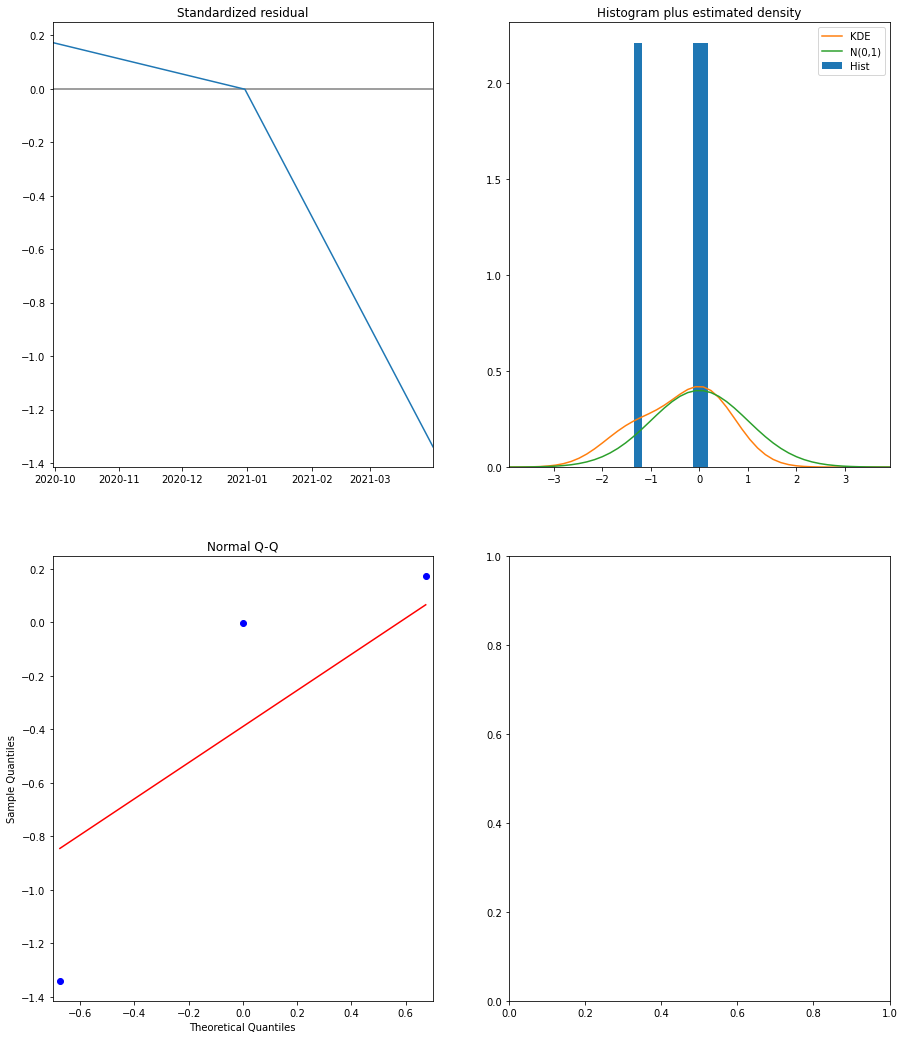

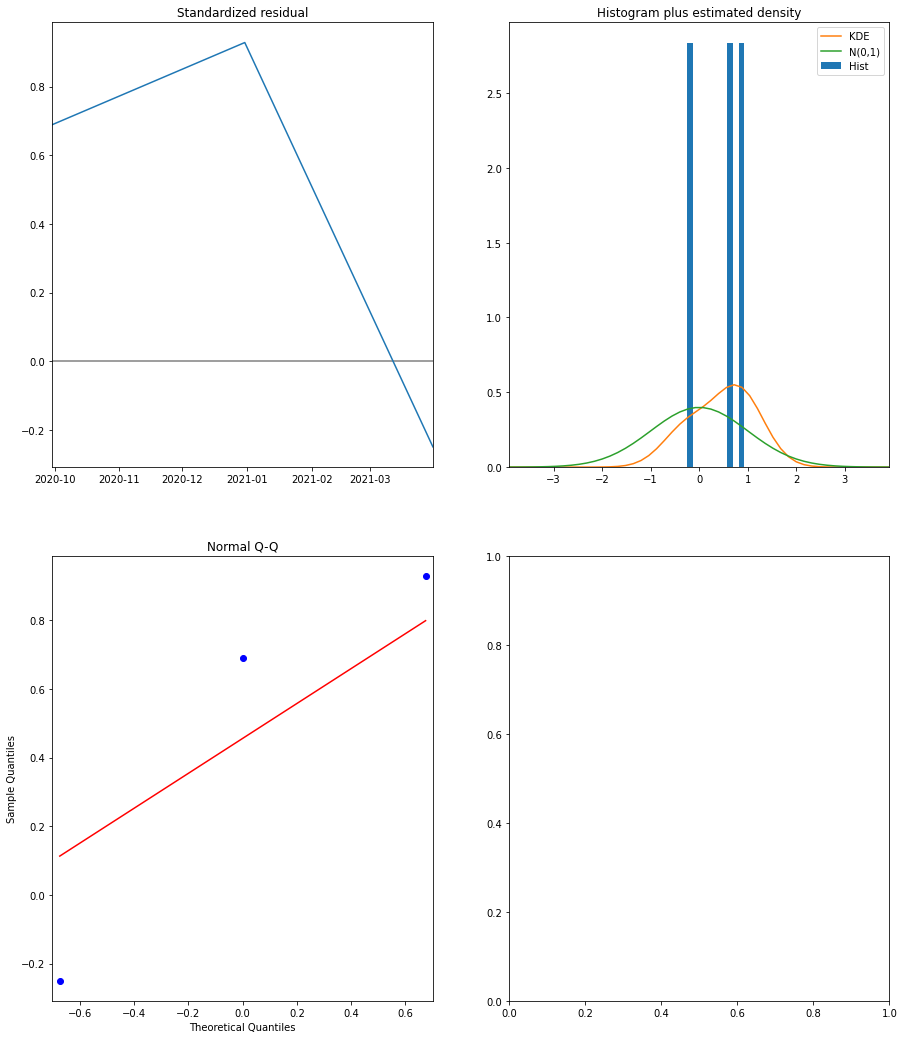

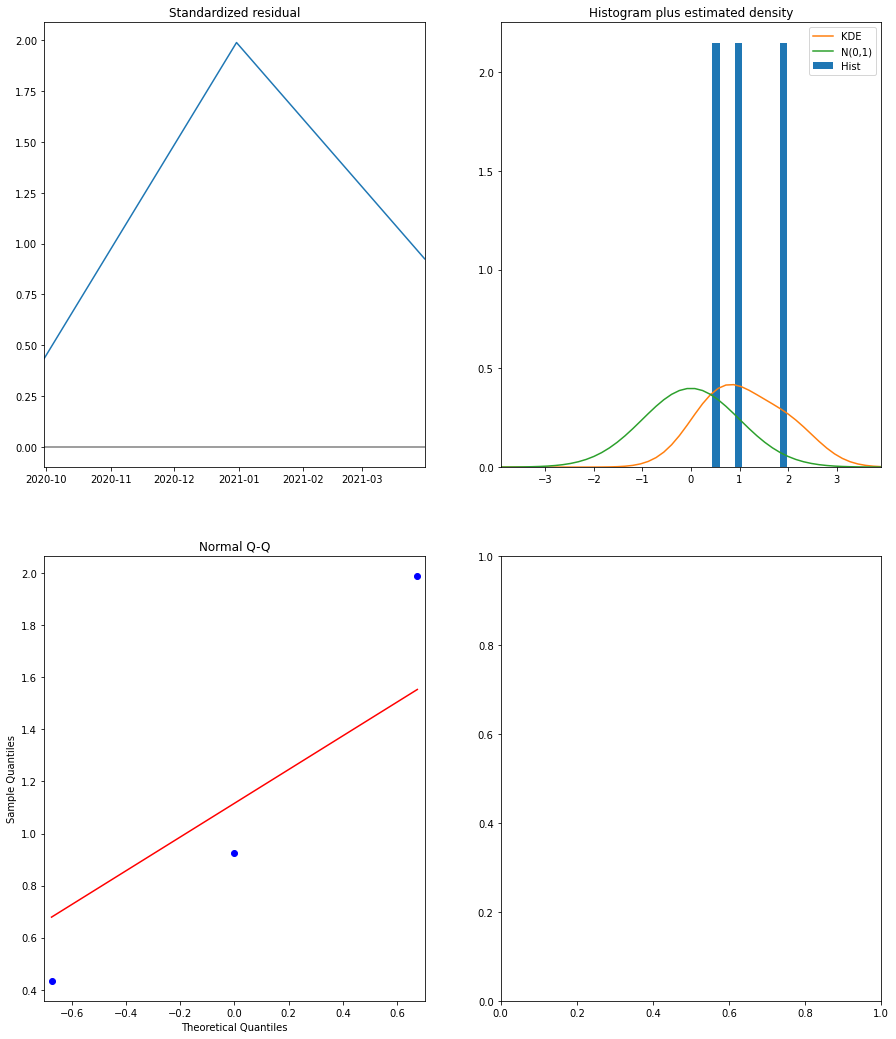

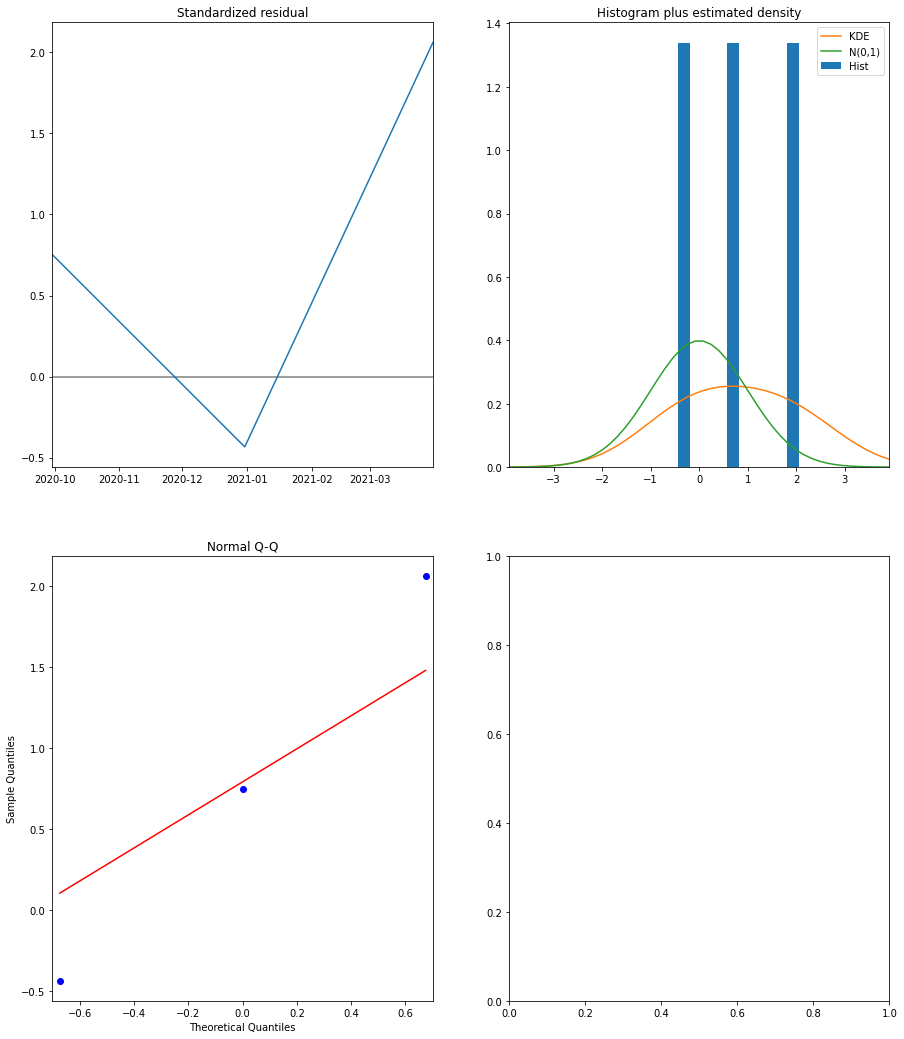

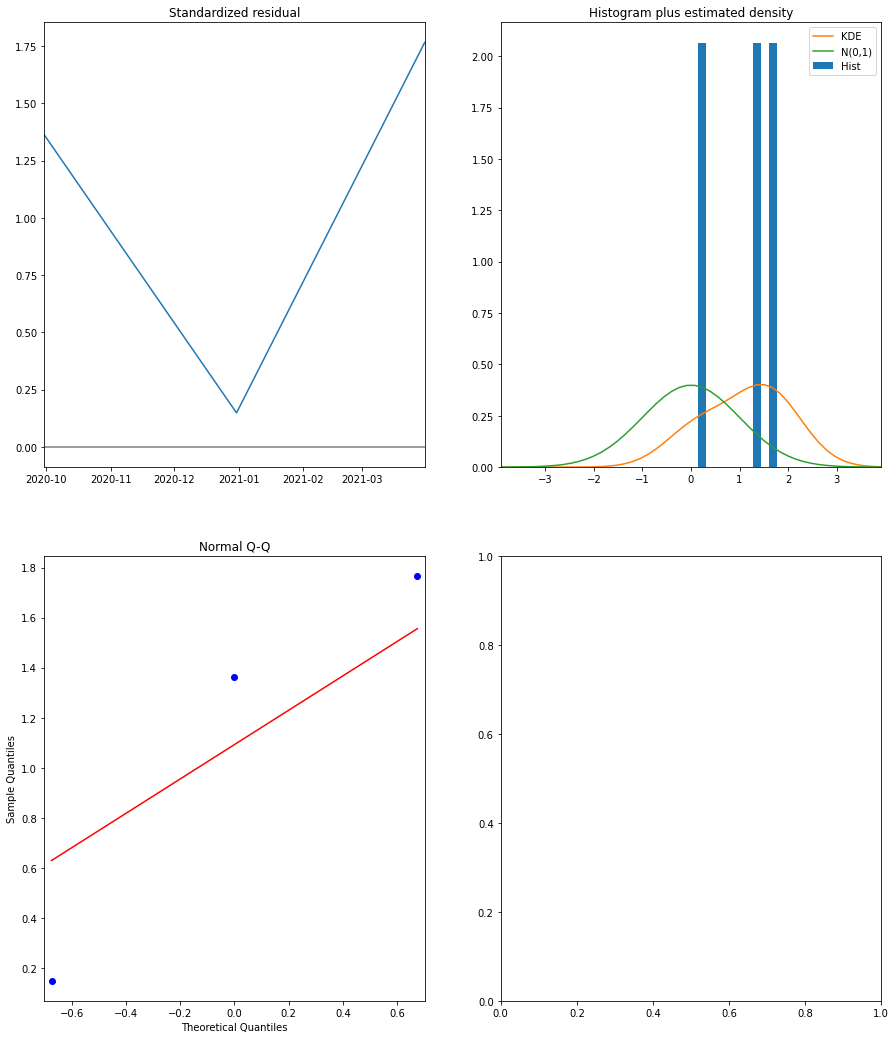

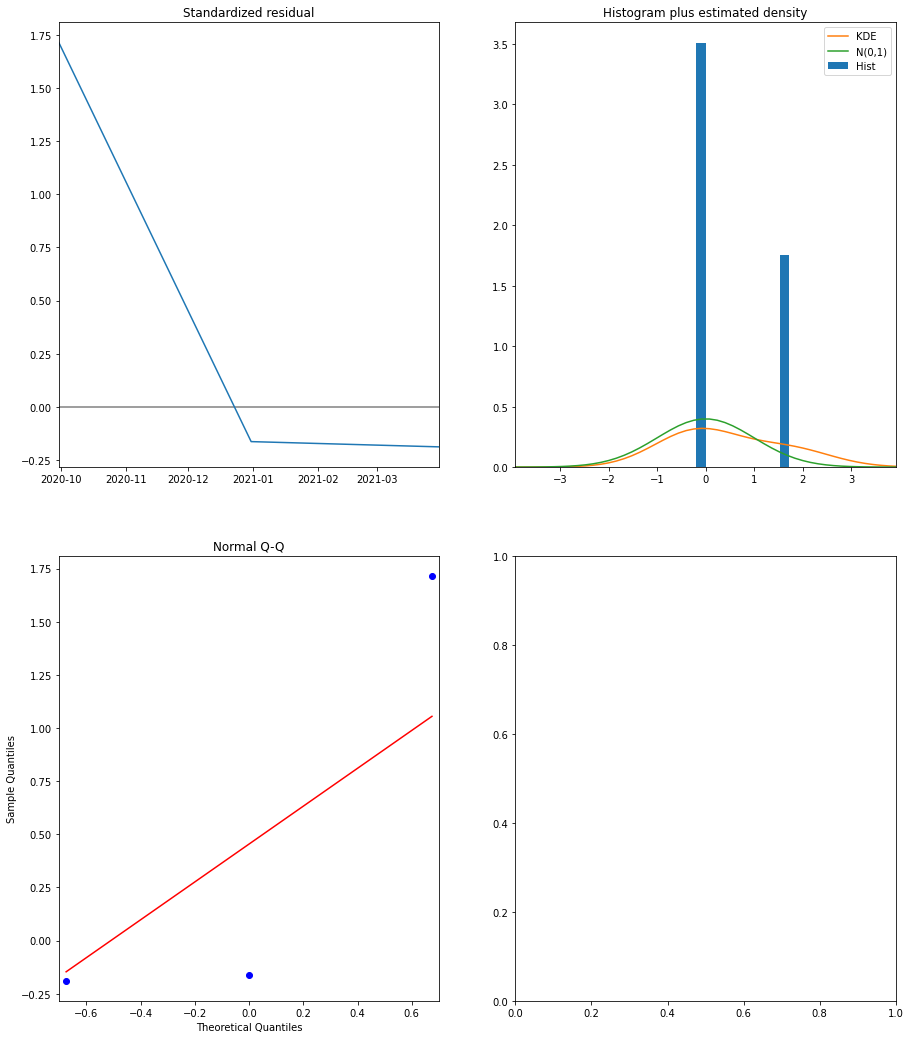

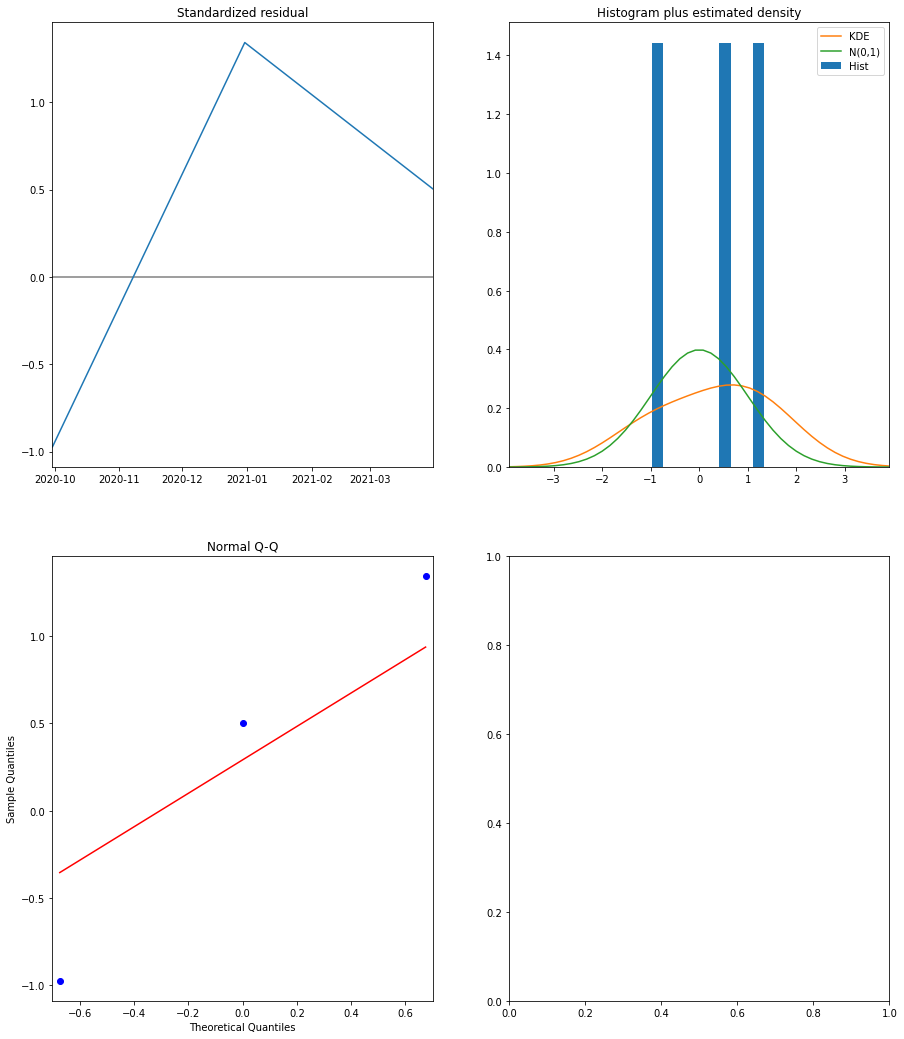

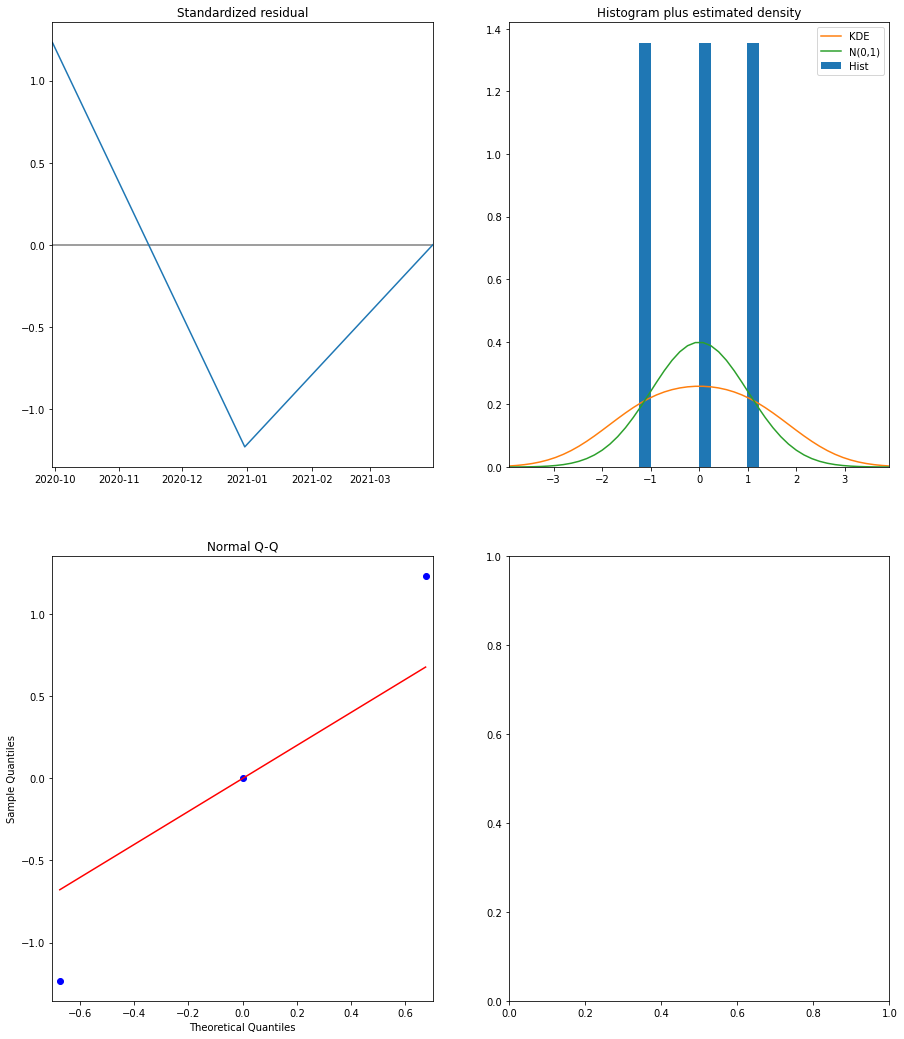

In [ ]:
targets = ['Closed Revenue', 'Lost Revenue', 'Qualify Revenue', 'Problem Revenue', 'Solution Revenue', 'Proof Revenue', 'Agreement Revenue', 'Order Revenue']
figs = []
for target in targets:
  fig = getSarimaxModel('Quarter', dfQuarterTrain, dfQuarterTest, target, startDate = '03-31-2021', endDate = '12-31-2021', showFig=True, rangeMax = 1, s = [0])
  figs.append(fig)

In [ ]:
dfQuarterTrain

,Partner ID,Forecasted Office Users,Forecasted Annual Revenue,Opportunity,Closed Revenue,Lost Revenue,Qualify Revenue,Problem Revenue,Solution Revenue,Proof Revenue,Agreement Revenue,Order Revenue
CreateDateTime,,,,,,,,,,,,
2020-03-31,19380615,108114.0,19853420.38,333,362648.64,18290358.34,537757.66,531972.69,130683.05,0.00,0.00,0.00
2020-06-30,19843906,213441.0,17695431.84,312,1551728.27,14776226.22,526920.01,671760.69,163785.07,0.00,5011.58,0.00
2020-09-30,33407748,143052.0,23437362.58,476,1666834.88,14783937.79,1046774.27,3163161.75,829629.68,1944405.45,0.00,2618.76
2020-12-31,33841193,266935.0,15105084.77,464,1665397.17,7109789.03,3424574.44,1724676.59,902172.83,255449.60,23025.11,0.00
2021-03-31,31941096,140322.0,19495934.71,420,771626.93,2279686.58,4530421.99,8558657.12,1764796.17,1347822.06,242923.86,0.00


In [ ]:
from sklearn.linear_model import LinearRegression
train = dfQuarterTrain.reset_index()
test = dfQuarterTest.reset_index()
Xtrain = np.array(dfQuarterTrain.index)
ytrain = np.array(dfQuarterTrain['Closed Revenue'])
Xtest = np.array(pd.to_datetime(['2021-06-30', '2021-09-30', '2021-12-31'], yearfirst=True)).reshape(-1,1)
linear_model = LinearRegression()
linear_model.fit(X = train['CreateDateTime'], y=train['Closed Revenue'])
pred = linear_model.predict(np.array(pd.Series(list(pd.to_datetime(['2021-06-30','2021-09-30','2021-12-31'], yearfirst=True)))).reshape(-1,1))
# pred

ValueError: ignored

In [ ]:
pd.Series(list(pd.to_datetime(['2021-06-30','2021-09-30','2021-12-31'], yearfirst=True)), )[]


KeyError: ignored

In [ ]:
dfQuarter.reset_index()

,CreateDateTime,Partner ID,Forecasted Office Users,Forecasted Annual Revenue,Opportunity,Closed Revenue,Lost Revenue,Qualify Revenue,Problem Revenue,Solution Revenue,Proof Revenue,Agreement Revenue,Order Revenue,Channel Manager 4,Channel Manager 4 Revenue,Channel Manager 4 Lost Revenue,Channel Manager 4 Qualify Revenue,Channel Manager 4 Problem Revenue,Channel Manager 4 Solution Revenue,Channel Manager 4 Proof Revenue,Channel Manager 4 Agreement Revenue,Channel Manager 4 Order Revenue,Channel Manager 4 Closed Sale,Channel Manager 6,Channel Manager 6 Revenue,Channel Manager 6 Lost Revenue,Channel Manager 6 Qualify Revenue,Channel Manager 6 Problem Revenue,Channel Manager 6 Solution Revenue,Channel Manager 6 Proof Revenue,Channel Manager 6 Agreement Revenue,Channel Manager 6 Order Revenue,Channel Manager 6 Closed Sale,Channel Manager 3,Channel Manager 3 Revenue,Channel Manager 3 Lost Revenue,Channel Manager 3 Qualify Revenue,Channel Manager 3 Problem Revenue,Channel Manager 3 Solution Revenue,Channel Manager 3 Proof Revenue,...,Partner 393 Closed Sale,Partner 371,Partner 371 Revenue,Partner 371 Lost Revenue,Partner 371 Qualify Revenue,Partner 371 Problem Revenue,Partner 371 Solution Revenue,Partner 371 Proof Revenue,Partner 371 Agreement Revenue,Partner 371 Order Revenue,Partner 371 Closed Sale,Partner 518,Partner 518 Revenue,Partner 518 Lost Revenue,Partner 518 Qualify Revenue,Partner 518 Problem Revenue,Partner 518 Solution Revenue,Partner 518 Proof Revenue,Partner 518 Agreement Revenue,Partner 518 Order Revenue,Partner 518 Closed Sale,Partner 127,Partner 127 Revenue,Partner 127 Lost Revenue,Partner 127 Qualify Revenue,Partner 127 Problem Revenue,Partner 127 Solution Revenue,Partner 127 Proof Revenue,Partner 127 Agreement Revenue,Partner 127 Order Revenue,Partner 127 Closed Sale,0. Downgraded,7. Closed Won,1. Qualify,2. Problem,3. Solution,4. Proof,5. Agreement,6. Order,Total Churn
0,2020-03-31,19380615,108114.0,19853420.38,333,362648.64,18290358.34,537757.66,531972.69,130683.05,0.00,0.00,0.00,65,80623.42,2926000.71,209438.36,10841.50,83017.08,0,0.00,0,6,25,4729.58,1075306.87,64448.52,11548.07,4477.60,0.00,0.00,0,3,85,53788.38,1399956.68,0.00,320482.05,0.00,0.00,...,0,1,7571.29,0,0,0,0,0,0,0,1,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,240,74,10,5,4,0,0,0,0.78
1,2020-06-30,19843906,213441.0,17695431.84,312,1551728.27,14776226.22,526920.01,671760.69,163785.07,0.00,5011.58,0.00,58,447537.70,2099678.55,151807.69,278682.01,50112.97,0,5011.58,0,10,41,157594.78,4442354.71,180691.65,67564.05,0.00,0.00,0.00,0,4,77,100244.12,2111174.25,130777.76,17546.28,0.00,0.00,...,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,185,93,13,16,4,0,1,0,0.70
2,2020-09-30,33407748,143052.0,23437362.58,476,1666834.88,14783937.79,1046774.27,3163161.75,829629.68,1944405.45,0.00,2618.76,103,764723.91,5160318.38,618917.37,1265754.15,356105.10,0,0.00,0,25,88,208292.43,3838714.12,41381.45,197437.56,258384.96,1814816.77,0.00,0,23,80,56734.63,303820.48,0.00,46223.58,135350.40,0.00,...,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,1,0,0.0,0,0,0,0,0,0,0,263,143,22,27,16,4,0,1,0.70
3,2020-12-31,33841193,266935.0,15105084.77,464,1665397.17,7109789.03,3424574.44,1724676.59,902172.83,255449.60,23025.11,0.00,84,409906.26,1855892.66,866424.21,657025.92,392684.90,0,0.00,0,15,115,490153.65,2326314.63,678407.07,291581.59,105221.93,56744.37,18312.35,0,16,47,32762.84,200552.47,72819.12,43141.52,0.00,0.00,...,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,219,88,61,50,35,7,4,0,0.81
4,2021-03-31,31941096,140322.0,19495934.71,420,771626.93,2279686.58,4530421.99,8558657.12,1764796.17,1347822.06,242923.86,0.00,58,39284.84,511001.00,983976.41,805271.52,303838.62,0,94102.70,0,6,91,225903.82,697459.25,1125614.91,5996195.51,474676.39,576774.63,0.00,0,10,42,35578.18,56292.86,38576.17,13662.46,32054.37,2765.31,...,0,0,0.00,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,95,77,90,97,43,11,7,0,0.82


In [ ]:
def getPreds(dfTrain, future, target):
  from sklearn.linear_model import LinearRegression
  Xtrain = dfTrain.reset_index()['CreateDateTime']
  ytrain = dfTrain[target]
  Xtest = future
  linear_model = LinearRegression()
  linear_model.fit(X = Xtrain, y=ytrain)
  pred = linear_model.predict(Xtrain)
  return pred

future = np.array(pd.to_datetime(['2021-06-30', '2021-09-30', '2021-12-31'], yearfirst=True)).reshape(-1,1)
future = np.array(dfQuarterTest.index).reshape(-1,1)
lost_preds = getPreds(dfQuarterTrain, future,'Lost Revenue')
closed_preds = getPreds(dfQuarterTrain, future,'Closed Revenue')
qualify_preds = getPreds(dfQuarterTrain, future,'Qualify Revenue')
problem_preds = getPreds(dfQuarterTrain, future,'Problem Revenue')
solution_preds = getPreds(dfQuarterTrain, future,'Solution Revenue')
proof_preds = getPreds(dfQuarterTrain, future,'Proof Revenue')
agreement_preds = getPreds(dfQuarterTrain, future,'Agreement Revenue')
order_preds = getPreds(dfQuarterTrain, future,'Order Revenue')

ValueError: ignored

In [ ]:
getPreds(dfMonthTrain, dfMonthTest,'Lost Revenue')

In [ ]:
dfMonth

In [ ]:

fig2 = go.Figure(
    data = [
(go.Bar(name = 'Opportunities Per Month',x = dfMonth.index, y = dfMonth['Opportunity']*10000, marker_color = 'lightblue')),
(go.Scatter(name = 'Lost Revenue',x = dfMonth.index, y = dfMonth['Lost Revenue'], line = {'color':'red'})),
(go.Scatter(name = 'Closed Revenue',x = dfMonth.index, y = dfMonth['Closed Revenue'], line = {'color':'black'})),
(go.Scatter(name = 'Qualify Revenue',x = dfMonth.index, y = dfMonth['Qualify Revenue'], line = {'color':'orange'})),
(go.Scatter(name = 'Problem Revenue',x = dfMonth.index, y = dfMonth['Problem Revenue'], line = {'color':'yellow'})),
(go.Scatter(name = 'Solution Revenue',x = dfMonth.index, y = dfMonth['Solution Revenue'], line = {'color':'greenyellow'})),
(go.Scatter(name = 'Proof Revenue',x = dfMonth.index, y = dfMonth['Proof Revenue'], line = {'color':'cyan'})),
(go.Scatter(name = 'Agreement Revenue',x = dfMonth.index, y = dfMonth['Agreement Revenue'], line = {'color':'blue'})),
(go.Scatter(name = 'Order Revenue',x = dfMonth.index, y = dfMonth['Order Revenue'], line = {'color':'green'})),

(go.Scatter(name = 'Lost Revenue Prediction',x = dfMonthTest.index, y = lost_preds, line = {'color':'red'})),
(go.Scatter(name = 'Closed Revenue Prediction',x = dfMonthTest.index, y = closed_preds, line = {'color':'black'})),
(go.Scatter(name = 'Qualify Revenue Prediction',x = dfMonthTest.index, y = qualify_preds, line = {'color':'orange'})),
(go.Scatter(name = 'Problem Revenue Prediction',x = dfMonthTest.index, y = problem_preds, line = {'color':'yellow'})),
(go.Scatter(name = 'Solution Revenue Prediction',x = dfMonthTest.index, y = solution_preds, line = {'color':'greenyellow'})),
(go.Scatter(name = 'Proof Revenue Prediction',x = dfMonthTest.index, y = proof_preds, line = {'color':'cyan'})),
(go.Scatter(name = 'Agreement Revenue Prediction',x = dfMonthTest.index, y = agreement_preds, line = {'color':'blue'})),
(go.Scatter(name = 'Order Revenue Prediction',x = dfMonthTest.index, y = order_preds, line = {'color':'green'})),
    ])
fig2.show()

In [ ]:
Xtrain = dfMonthTrain.drop(columns = ['Qualify Revenue'])
ytrain = dfMonthTrain['Qualify Revenue']
Xtest = dfMonthTest.drop(columns = ['Qualify Revenue'])
linear_model = LinearRegression()
linear_model.fit(X = Xtrain, y=ytrain)
pred = linear_model.predict(Xtest)
pred

In [ ]:
fig2 = go.Figure(
    data = [
(go.Bar(name = 'Opportunities Per Month',x = dfQuarter.index, y = dfQuarter['Opportunity']*10000, marker_color = 'lightblue')),
(go.Scatter(name = 'Lost Revenue',x = dfQuarter.index, y = dfQuarter['Lost Revenue'], line = {'color':'red'})),
(go.Scatter(name = 'Closed Revenue',x = dfQuarter.index, y = dfQuarter['Closed Revenue'], line = {'color':'green'})),
(go.Scatter(name = 'Closed Revenue Trendline',x = dfQuarterTest.index, y = closed_pred+dfQuarter['Closed Revenue'][-1], line = {'color':'green'})),
(go.Scatter(name = 'Lost Revenue Trendline',x = dfQuarterTest.index, y = lost_pred+dfQuarter['Lost Revenue'][-1], line = {'color':'red'})),
    ])
fig2.show()

In [ ]:
fig2 = go.Figure(data=[
    go.Scatter( x = dfMonth.index, y = dfMonth['Forecasted Annual Revenue'].diff(1)/dfMonth['Forecasted Annual Revenue']),
    go.Scatter( x = dfMonth.index, y = dfMonth['Closed Revenue'].diff(1)/dfMonth['Closed Revenue'], line = {'color':'green'}),
    # go.Bar(x = dfQuarter.index, y = dfQuarter['Opportunity']*10000),
    go.Scatter(x = dfQuarter.index, y = [0 for x in dfQuarter.index]),
])
fig2.show()

In [ ]:
fig2 = go.Figure(data=[
    go.Scatter( x = dfQuarter[:'03-31-2021'].index, y = dfQuarter['Closed Revenue'].diff(1)/dfQuarter['Closed Revenue'].shift(1)*100),
    go.Scatter( x = dfQuarter[:'03-31-2021'].index, y = dfQuarter['Forecasted Annual Revenue'].diff(1)/dfQuarter['Forecasted Annual Revenue'].shift(1)*100),
])
fig2.show()

In [ ]:
dfQuarter['Channel Manager 4']

CreateDateTime
2020-03-31     65
2020-06-30     58
2020-09-30    103
2020-12-31     84
2021-03-31     58
Freq: Q-DEC, Name: Channel Manager 4, dtype: int64

In [ ]:
fig = go.Figure(
  data = [go.Scatter(
      x = round(dfQuarter[f'Channel Manager {i}'].diff(1)/dfQuarter[f'Channel Manager {i}'].shift(1)*100,0).index, 
      y = round(dfQuarter[f'Channel Manager {i}'].diff(1)/dfQuarter[f'Channel Manager {i}'].shift(1)*100,0),
      name = f'Channel Manager {i}',
      mode="lines+text+markers",) for i in range(1,8)],

      layout = {
        'title': 'Q/Q Opportunities by Channel Manager',
         'width' : 900,
        'height' : 525,
        'xaxis' : {
            'title' : 'Reporting Quarter',
            'tickangle' : -90,
            # 'nticks' : 16
        },
        'yaxis' : {
            'title' : 'Percent change',
        },
      },)
fig.show()